In [1]:
import json
import numpy as np
import pandas as pd
import random
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
file = "./renttherunway_final_data.json"
df = pd.read_json(file,lines=True)


In [3]:
# transfer bust size into bust size and cups
df=df.dropna()
df['cups'] = df['bust size'].str.extract(r'([a-z])')
labels = df['cups'].astype('category').cat.categories.tolist()
replace_map = {'cups' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
print('--- map cups to numerical value ---')
print(replace_map)
df.replace(replace_map, inplace=True)
df['bust size'] = df['bust size'].str.extract('(\d+)').astype(int)
# remove lbs after 'weight'
df['weight'] = df['weight'].str.extract('(\d+)').astype(int)
# parse height to usable numerical format
def parse_height(ht):
    ht_ = ht.split("' ")
    ft_ = float(ht_[0])
    in_ = float(ht_[1].replace("\"",""))
    return (12*ft_) + in_
df['height'] = df['height'].apply(lambda x:parse_height(x))
# change 'party: cocktail' in 'rented for' to 'others'
df.loc[df['rented for'] == 'party: cocktail', df.columns == 'rented for'] = 'other'

--- map cups to numerical value ---
{'cups': {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9}}


In [4]:
df=df.drop(columns=['user_id', 'item_id','review_date','review_summary','review_text','fit'])

In [5]:
df['category'].unique()

array(['romper', 'gown', 'dress', 'sheath', 'leggings', 'sweater',
       'jacket', 'shirtdress', 'jumpsuit', 'shift', 'top', 'shirt',
       'mini', 'skirt', 'maxi', 'pants', 'suit', 'coat', 'blouse',
       'trench', 'cape', 'bomber', 'blazer', 'vest', 'duster', 'ballgown',
       'tank', 'poncho', 'frock', 'tunic', 'cardigan', 'down', 'culottes',
       'midi', 'legging', 'print', 'pant', 'knit', 'culotte',
       'sweatshirt', 'peacoat', 'trouser', 'kaftan', 'overalls', 'jogger',
       'tee', 'combo', 'henley', 'blouson', 'pullover', 'turtleneck',
       'trousers', 'overcoat', 'hoodie', 't-shirt', 'caftan', 'tight',
       'kimono', 'cami', 'for', 'crewneck', 'skirts', 'parka',
       'buttondown', 'skort', 'sweatershirt', 'jeans', 'sweatpants'],
      dtype=object)

In [6]:
df.loc[df['category'].isin(['sweater','shirt','blouse','vest','tank','tunic','print','sweatshirt',
                            'tee','blouson','turtleneck','hoodie','t-shirt','cami','crewneck',
                            'buttondown','sweatershirt'
                           ]),df.columns=='category']='tops'
df.loc[df['category'].isin(['pants','down','culottes','pant','trouser','culotte','jogger',
                            'trousers','jeans', 'sweatpants'
                           ]),df.columns=='category']='bottoms'
df.loc[df['category'].isin(['ballgown']),df.columns=='category']='gown'
df.loc[df['category'].isin(['leggings','legging']),df.columns=='category']='active'
df.loc[df['category'].isin(['jacket','trench','cape','bomber','blazer','duster','poncho',
                            'cardigan','peacoat','pullover','overcoat','parka'
                           ]),df.columns=='category']='coat'
df.loc[df['category'].isin(['mini','midi','skirts']),df.columns=='category']='skirt'
df.loc[df['category'].isin(['jumpsuit']),df.columns=='category']='romper'
df.loc[df['category'].isin(['sheath','shift','maxi','shirtdress','frock','kaftan','caftan'
                           ]),df.columns=='category']='dress'
df.loc[df['category'].isin(['overalls','combo','henley','tight','kimono','for','skort']),df.columns=='category']='other'

In [7]:
df.info()
df= pd.get_dummies(df, columns=['body type','category','rented for'])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146381 entries, 0 to 192543
Data columns (total 10 columns):
age           146381 non-null float64
body type     146381 non-null object
bust size     146381 non-null int64
category      146381 non-null object
height        146381 non-null float64
rating        146381 non-null float64
rented for    146381 non-null object
size          146381 non-null int64
weight        146381 non-null int64
cups          146381 non-null int64
dtypes: float64(3), int64(4), object(3)
memory usage: 12.3+ MB


In [8]:
df.head()

,age,bust size,height,rating,size,weight,cups,body type_apple,body type_athletic,body type_full bust,...,category_top,category_tops,rented for_date,rented for_everyday,rented for_formal affair,rented for_other,rented for_party,rented for_vacation,rented for_wedding,rented for_work
0,28.0,34,68.0,10.0,14,137,4,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,36.0,34,66.0,10.0,12,132,2,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,34.0,34,65.0,8.0,8,135,3,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,27.0,34,69.0,10.0,12,145,2,0,1,0,...,0,0,0,0,0,0,0,0,1,0
5,45.0,32,68.0,8.0,8,138,2,0,1,0,...,0,0,1,0,0,0,0,0,0,0


In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

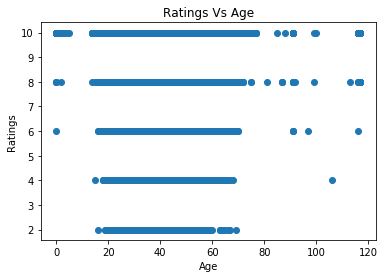

In [10]:
plt.scatter(df['age'],df['rating'])
plt.ylabel('Ratings')
plt.xlabel('Age')
plt.title('Ratings Vs Age')
plt.show()

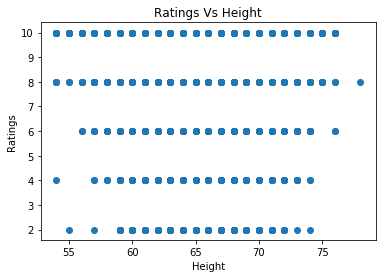

In [11]:
plt.scatter(df['height'],df['rating'])
plt.ylabel('Ratings')
plt.xlabel('Height')
plt.title('Ratings Vs Height')
plt.show()

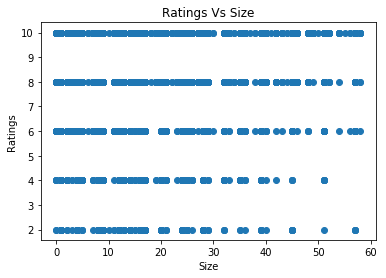

In [13]:
plt.scatter(df['size'],df['rating'])
plt.ylabel('Ratings')
plt.xlabel('Size')
plt.title('Ratings Vs Size')
plt.show()

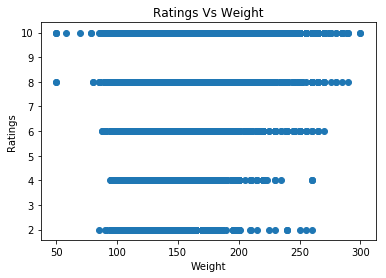

In [14]:
plt.scatter(df['weight'],df['rating'])
plt.ylabel('Ratings')
plt.xlabel('Weight')
plt.title('Ratings Vs Weight')
plt.show()

In [9]:
x=df.drop(columns=['rating'],axis=1)
y=df['rating']
x_train, x_test,y_train,y_test = train_test_split(x,y, test_size=0.33)

In [13]:
type(x_train)

pandas.core.frame.DataFrame

In [10]:
#linear regression
lg=LinearRegression(normalize=True).fit(x_train,y_train)
lg_train_pred=lg.predict(x_train)
lg_train_mse=mean_squared_error(y_train, lg_train_pred)
print('Linear Regression Train MSE:',lg_train_mse)
lg_test_pred=lg.predict(x_test)
lg_test_mse=mean_squared_error(y_test, lg_test_pred)
print('Linear Regression Test MSE:',lg_test_mse)

Linear Regression Train MSE: 2.039434912509223
Linear Regression Test MSE: 2.0369369619525313


In [11]:
#random forest regressor
# x_train,y_train= make_regression(n_features=36, n_informative=2,random_state=0, shuffle=False)
rm=RandomForestRegressor(max_depth=10,random_state=0,n_estimators=100,min_samples_split=5,min_samples_leaf=20)
rm.fit(x_train,y_train)
rm_train_pred=rm.predict(x_train)
rm_train_mse=mean_squared_error(y_train, rm_train_pred)
print('Random Forest Train MSE:',rm_train_mse)
rm_test_pred=rm.predict(x_test)
rm_test_mse=mean_squared_error(y_test, rm_test_pred)
print('Random Forest Test MSE:',rm_test_mse)

Random Forest Train MSE: 1.979360497595552
Random Forest Test MSE: 2.0282189264737602


In [12]:
#Gradient Boosting Regressor
gb=GradientBoostingRegressor(loss='quantile', learning_rate=0.0001, n_estimators=100, min_samples_split=2, max_depth=1).fit(x_train,y_train)
gb_train_pred=gb.predict(x_train)
gb_train_mse=mean_squared_error(y_train, gb_train_pred)
print('Gradient Boosting Regressor Train MSE:',gb_train_mse)
gb_test_pred=gb.predict(x_test)
gb_test_mse=mean_squared_error(y_test, gb_test_pred)
print('Gradient Boosting Regressor Test MSE:',gb_test_mse)

Gradient Boosting Regressor Train MSE: 2.913280652561815
Gradient Boosting Regressor Test MSE: 2.9038214714528214
